***PART A***

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import resample_poly

In [ ]:
#import file
wav_file = 'exam-1.wav'

In [3]:
# Load wav file
samplerate, data = wavfile.read(wav_file)

In [4]:
# Check if stereo or mono
if data.ndim == 1:
    channels = 1
else:
    channels = data.shape[1]

In [5]:
# Duration in seconds
duration = data.shape[0] / samplerate

print(f"Sampling rate: {samplerate} Hz")
print(f"Number of channels: {channels}")
print(f"Duration: {duration:.2f} seconds")

Sampling rate: 44100 Hz
Number of channels: 2
Duration: 27.99 seconds


In [6]:
# If stereo, analyze each channel separately
if channels == 1:
    channel_data = [data]
else:
    channel_data = [data[:, i] for i in range(channels)]

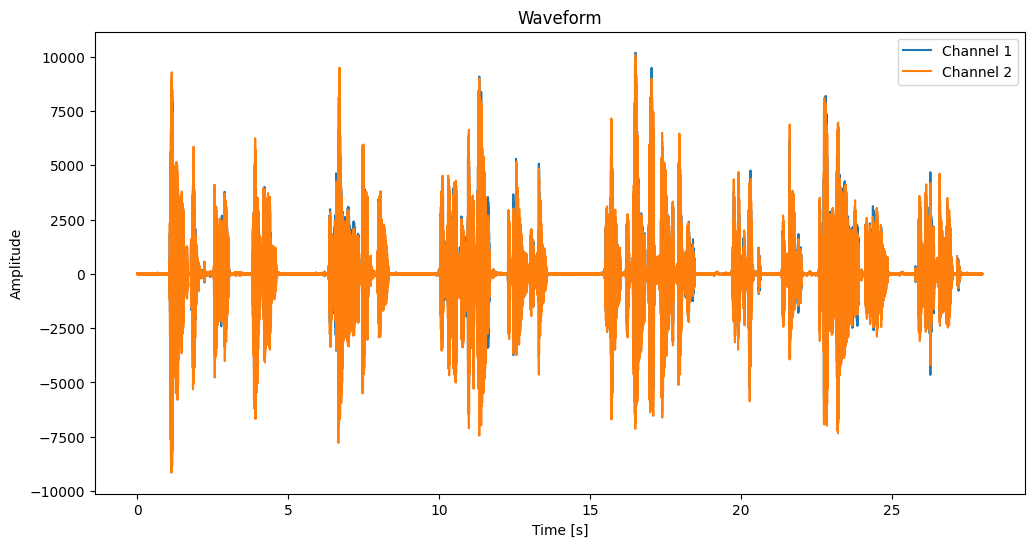

In [7]:
# Plot waveform for each channel
time = np.linspace(0., duration, data.shape[0])

plt.figure(figsize=(12, 6))
for i, ch_data in enumerate(channel_data):
    plt.plot(time, ch_data, label=f'Channel {i+1}')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.title('Waveform')
plt.legend()
plt.show()

In [8]:
# Calculate and print stats per channel
for i, ch_data in enumerate(channel_data):
    mean_amp = np.mean(ch_data)
    max_amp = np.max(ch_data)
    min_amp = np.min(ch_data)
    rms = np.sqrt(np.mean(ch_data**2))
    zero_crossings = np.sum(np.diff(np.sign(ch_data)) != 0)
    zero_crossing_rate = zero_crossings / duration

    print(f"\nChannel {i+1} characteristics:")
    print(f"  Mean amplitude: {mean_amp:.2f}")
    print(f"  Max amplitude: {max_amp}")
    print(f"  Min amplitude: {min_amp}")
    print(f"  RMS amplitude: {rms:.2f}")
    print(f"  Zero crossing rate: {zero_crossing_rate:.2f} crossings per second")


Channel 1 characteristics:
  Mean amplitude: -1.35
  Max amplitude: 10177
  Min amplitude: -6666
  RMS amplitude: 30.18
  Zero crossing rate: 5415.10 crossings per second

Channel 2 characteristics:
  Mean amplitude: -1.35
  Max amplitude: 10082
  Min amplitude: -9154
  RMS amplitude: 29.46
  Zero crossing rate: 4746.82 crossings per second


In [9]:
#2 Determining the frequency range of the audio signal and deciding the approriate sampling rate

In [10]:
# If stereo, just analyze the first channel
if data.ndim > 1:
    data = data[:, 0]

# Normalize data to float in [-1, 1] (if it is in int16)
if data.dtype == np.int16:
    data = data / 32768.0
elif data.dtype == np.int32:
    data = data / 2147483648.0
elif data.dtype == np.uint8:
    data = (data - 128) / 128.0

In [11]:
# Length of the signal
N = len(data)

# Compute FFT and frequency bins
freqs = np.fft.rfftfreq(N, d=1/samplerate)
fft_magnitude = np.abs(np.fft.rfft(data))

In [12]:
# Normalize magnitude
fft_magnitude = fft_magnitude / np.max(fft_magnitude)

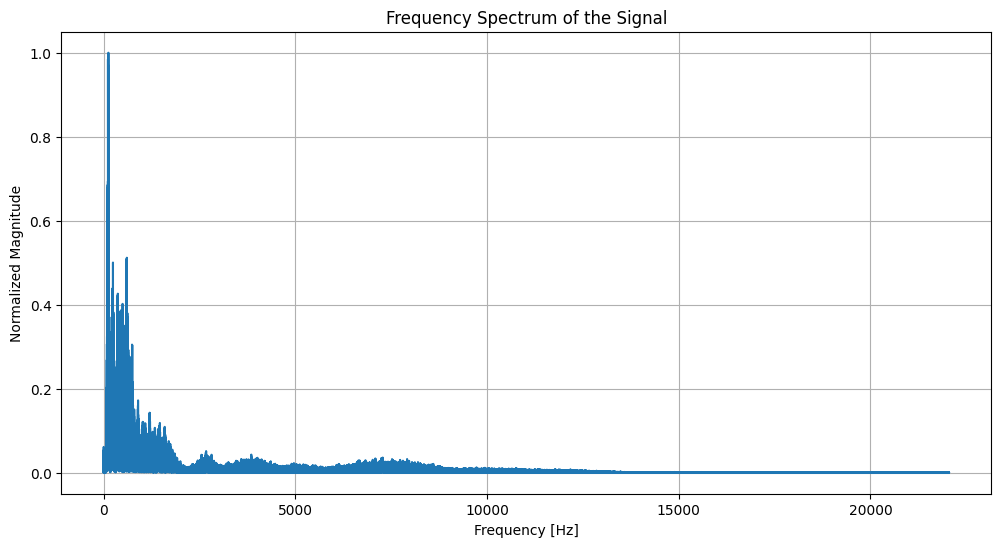

In [13]:
# Plot frequency spectrum
plt.figure(figsize=(12, 6))
plt.plot(freqs, fft_magnitude)
plt.title('Frequency Spectrum of the Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Normalized Magnitude')
plt.grid(True)
plt.show()

In [15]:
# Threshold for significant frequencies (e.g., 5% of max magnitude)
threshold = 0.05
significant_freqs = freqs[fft_magnitude > threshold]

if len(significant_freqs) == 0:
    print("No significant frequency components found above the threshold.")
else:
    max_freq = np.max(significant_freqs)
    recommended_sampling_rate = 2 * max_freq

    print(f"Significant frequency range: 0 Hz to {max_freq:.1f} Hz")
    print(f"Current sampling rate: {samplerate} Hz")
    print(f"Recommended minimum sampling rate to capture all info: {recommended_sampling_rate:.1f} Hz")

Significant frequency range: 0 Hz to 2675.1 Hz
Current sampling rate: 44100 Hz
Recommended minimum sampling rate to capture all info: 5350.2 Hz


### Explanation:

- **FFT** converts your time signal into the frequency domain.
- We plot the normalized magnitude spectrum so we can visually identify where the signal energy mostly lies.
- Frequencies with FFT magnitude above the 5% threshold (you can adjust) are considered significant.
- The highest significant frequency `max_freq` helps find the **minimum sampling rate** = `2 * max_freq` for lossless sampling.

In [17]:
#3. effects of sampling rate changes on audio quality
# Load original audio
wav_file = 'exam-1.wav'
original_sr, original_data = wavfile.read(wav_file)

In [18]:
# Use first channel if stereo
if original_data.ndim > 1:
    original_data = original_data[:, 0]

# Normalize data to float32 in range [-1, 1]
if original_data.dtype == np.int16:
    original_data = original_data.astype(np.float32) / 32768
elif original_data.dtype == np.int32:
    original_data = original_data.astype(np.float32) / 2147483648
elif original_data.dtype == np.uint8:
    original_data = (original_data.astype(np.float32) - 128) / 128

In [ ]:
# Define downsample rates to test
test_rates = [8000, 16000,44100,5350.2, 44100*2 ] #we have lower samples, recommended 2*max_freq, original rate and higher rate

In [20]:
# Create time axis for plotting (first 0.05 seconds to visualize waveform)
duration_to_plot = 0.05
samples_to_plot = int(original_sr * duration_to_plot)
time_axis = np.linspace(0, duration_to_plot, samples_to_plot)

In [21]:
def plot_waveforms(original, reconstructed, fs, title):
    plt.figure(figsize=(12, 4))
    plt.plot(time_axis, original[:samples_to_plot], label='Original')
    plt.plot(time_axis, reconstructed[:samples_to_plot], label='Reconstructed', alpha=0.7)
    plt.title(title)
    plt.xlabel('Time [seconds]')
    plt.ylabel('Amplitude')
    plt.legend()
    plt.grid()
    plt.show()


In [22]:
def plot_spectrum(signal, fs, title):
    N = len(signal)
    freqs = np.fft.rfftfreq(N, d=1/fs)
    fft_mag = np.abs(np.fft.rfft(signal))
    fft_mag /= np.max(fft_mag)
    plt.figure(figsize=(12, 4))
    plt.plot(freqs, fft_mag)
    plt.title(title)
    plt.xlabel('Frequency [Hz]')
    plt.ylabel('Normalized Magnitude')
    plt.grid()
    plt.show()

In [23]:
print(f"Original Sampling rate: {original_sr} Hz")

Original Sampling rate: 44100 Hz



Sampling Rate: 8000 Hz
Mean Squared Error after reconstruction: 0.000014


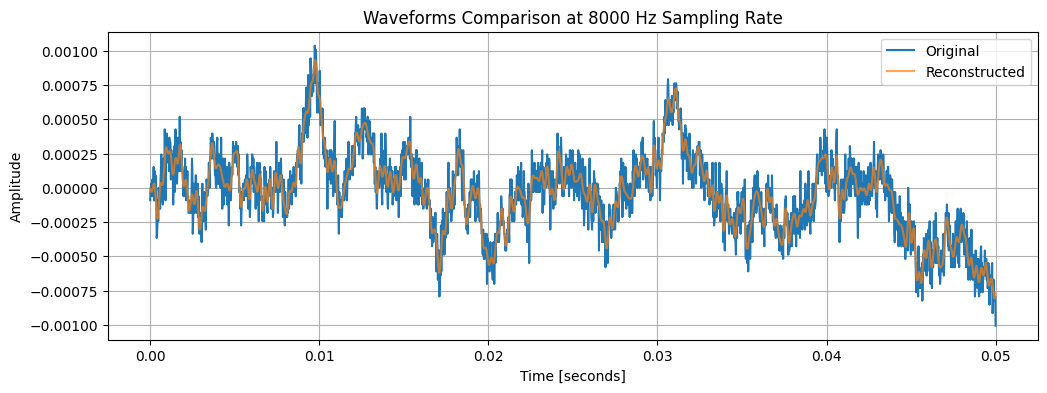

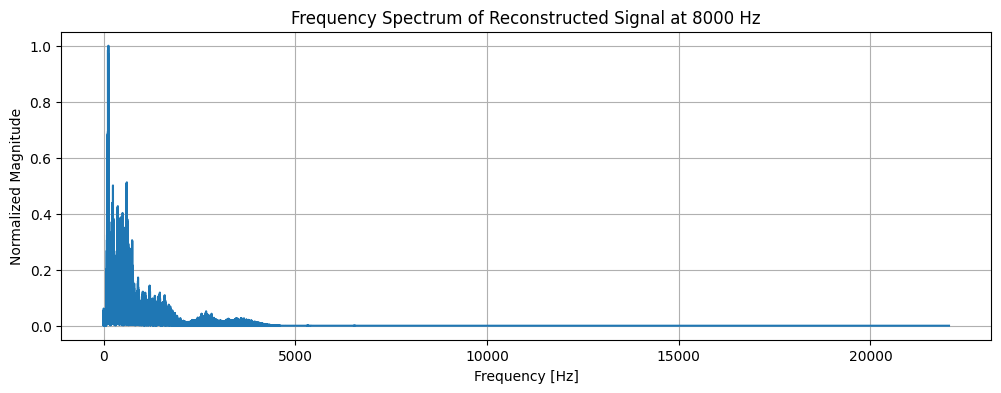


Sampling Rate: 16000 Hz
Mean Squared Error after reconstruction: 0.000004


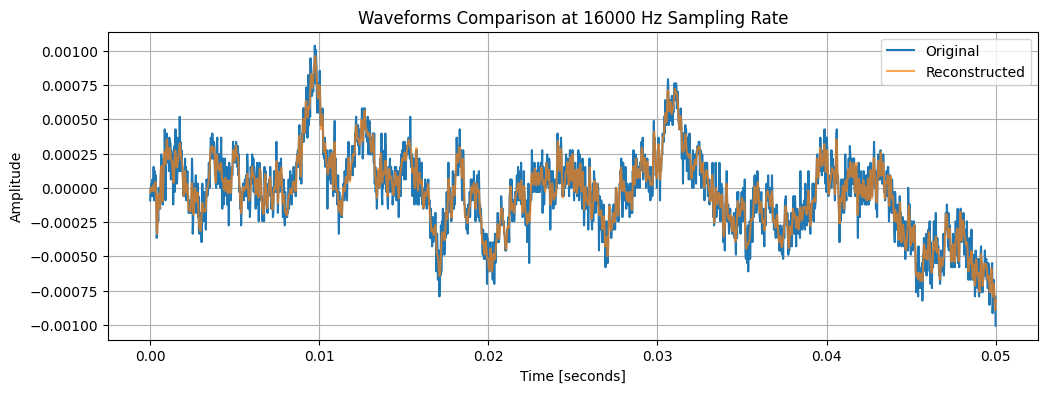

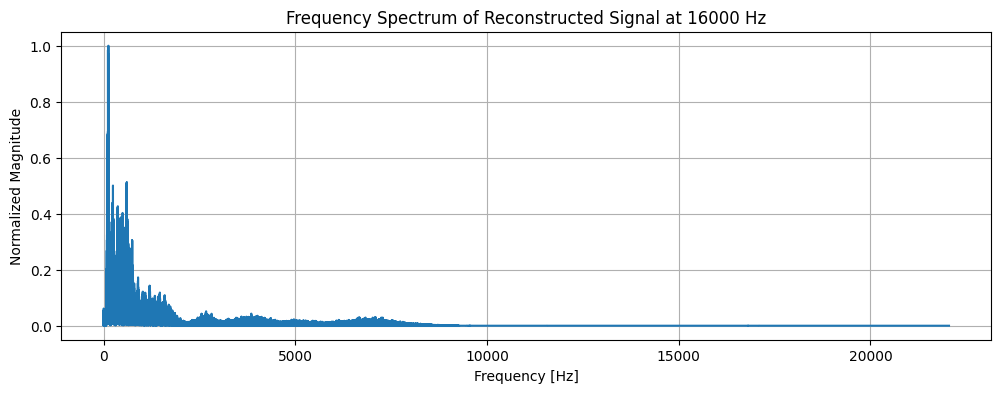


Sampling Rate: 44100 Hz
Mean Squared Error after reconstruction: 0.000000


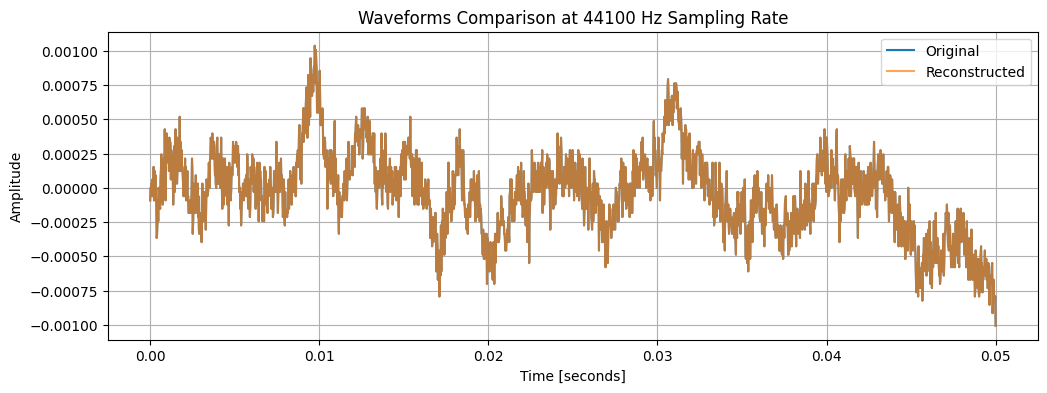

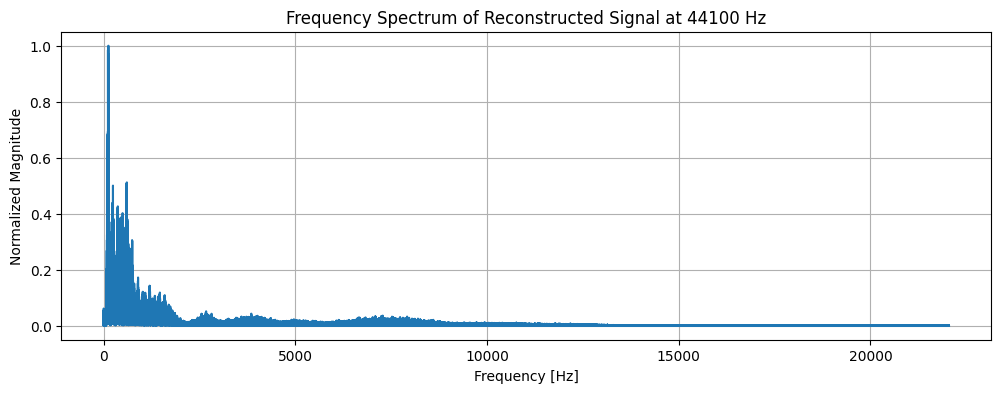


Sampling Rate: 5350.2 Hz
Mean Squared Error after reconstruction: 0.000019


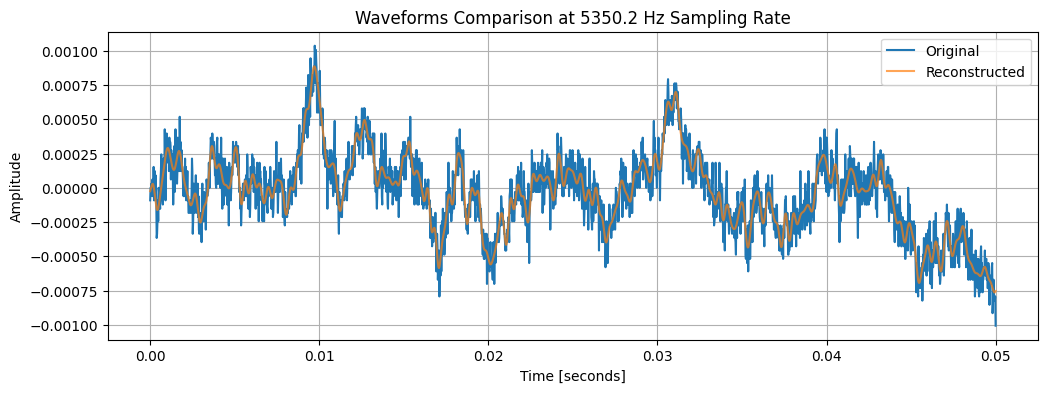

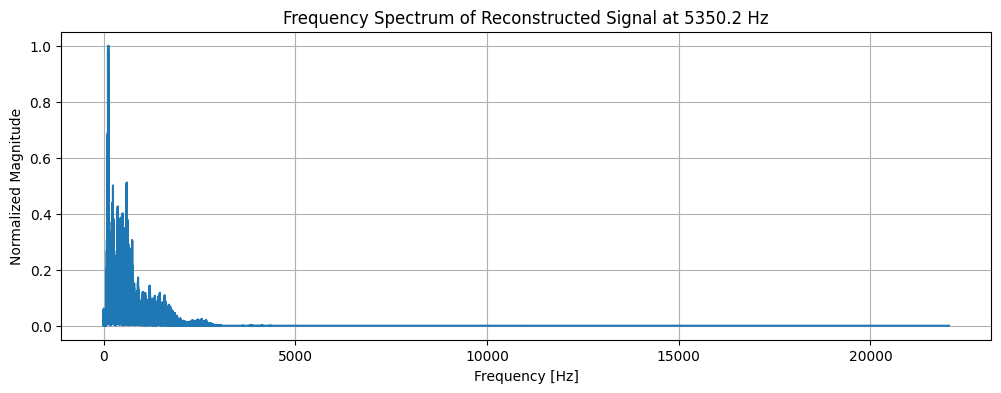


Sampling Rate: 88200 Hz
Mean Squared Error after reconstruction: 0.000000


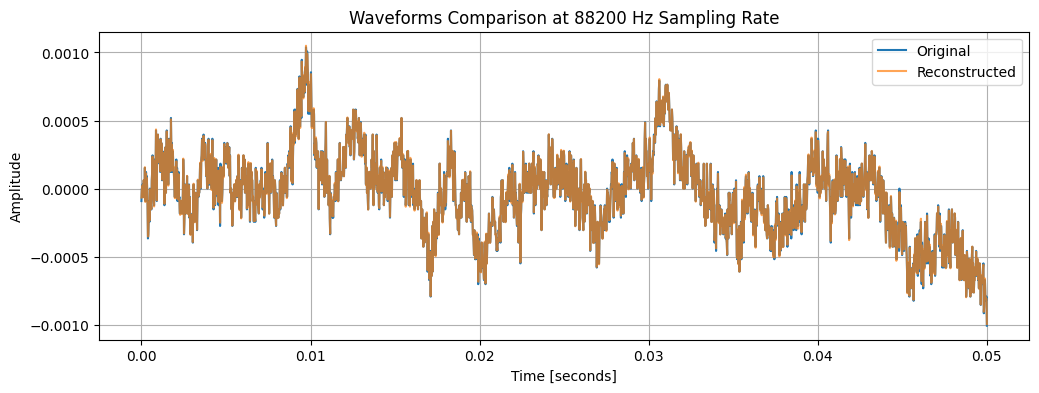

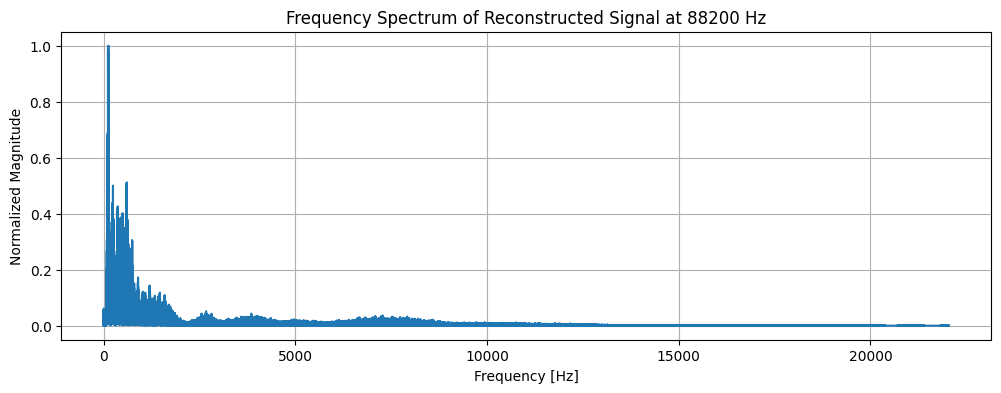

In [25]:
for rate in test_rates:
    # Downsample using polyphase method for good quality
    # Calculate gcd for resample_poly
    from math import gcd
    rate_int = int(round(rate))
    g = gcd(original_sr, rate_int)
    down = original_sr // g
    up = rate_int // g

    downsampled = resample_poly(original_data, up, down)

    # Upsample back to original rate to compare waveforms properly
    upsampled = resample_poly(downsampled, down, up)
    # Note: Length might differ slightly due to resampling
    min_len = min(len(original_data), len(upsampled))
    upsampled = upsampled[:min_len]
    original_trimmed = original_data[:min_len]

    # Calculate Mean Squared Error (MSE)
    mse = np.mean((original_trimmed - upsampled) ** 2)

    print(f"\nSampling Rate: {rate} Hz")
    print(f"Mean Squared Error after reconstruction: {mse:.6f}")

    # Plot waveforms
    plot_waveforms(original_trimmed, upsampled, original_sr,
                   f"Waveforms Comparison at {rate} Hz Sampling Rate")

    # Plot spectra
    plot_spectrum(upsampled, original_sr, f"Frequency Spectrum of Reconstructed Signal at {rate} Hz")

## Explanation and how to interpret:

- **Waveforms plot:** Shows how well the shape of signal is preserved after downsampling/upsampling.
- **Frequency spectrum plot:** Shows frequency content retained at different sampling rates.
- **MSE:** Lower MSE means the reconstructed signal is closer to original in time domain.
- **Sampling rate choices:**
  - ~8000 Hz corresponds roughly to telephone quality speech.
  - 16000 Hz is standard for many speech applications (e.g., Google speech).
  - 22050 Hz captures frequencies up to 11 kHz, near CD quality (44.1 kHz / 2).

## Conclusion:

For a **smart assistant**, **16 kHz** sampling rate is generally most suitable because:

- It preserves the full speech frequency range critical for intelligibility.
- It offers good reconstruction quality with relatively low MSE.
- It's commonly used in the industry, well-supported by speech models.
- It doesn't waste memory or compute resources like 88.2KHz or 44.1 kHz sampling might.

In [26]:
#PART B

In [58]:
# Load your original audio file
wav_file = 'exam-1.wav'
samplerate, data = wavfile.read(wav_file)

In [59]:
# Use first channel if stereo
if data.ndim > 1:
    data = data[:, 0]

# Normalize to float32 [-1,1]
if data.dtype == np.int16:
    data = data.astype(np.float32) / 32768
elif data.dtype == np.int32:
    data = data.astype(np.float32) / 2147483648
elif data.dtype == np.uint8:
    data = (data.astype(np.float32) - 128) / 128

duration = len(data) / samplerate
time = np.linspace(0, duration, len(data))

In [75]:
# Generate a sine wave tone to add: e.g., 150 Hz
tone_freq = 1500  # frequency in Hz
tone_amplitude = 0.001  # relative amplitude (adjust for audibility)

tone = tone_amplitude * np.sin(2 * np.pi * tone_freq * time)

# Composite signal: original + tone (make sure to avoid clipping)
composite = data + tone

In [76]:
# FFT analysis of composite signal
N = len(composite)
freqs = np.fft.rfftfreq(N, d=1/samplerate)
fft_vals = np.fft.rfft(composite)
magnitude = np.abs(fft_vals)
magnitude /= np.max(magnitude)  # normalize for plotting

In [87]:
# FFT analysis of org signal
N = len(data)
org_freqs = np.fft.rfftfreq(N, d=1/samplerate)
org_fft_vals = np.fft.rfft(data)
org_magnitude = np.abs(org_fft_vals)
org_magnitude /= np.max(org_magnitude)  # normalize for plotting

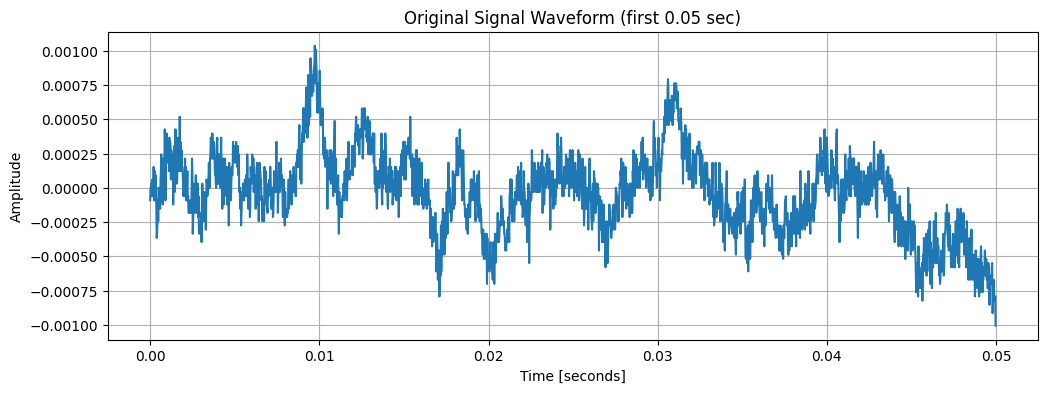

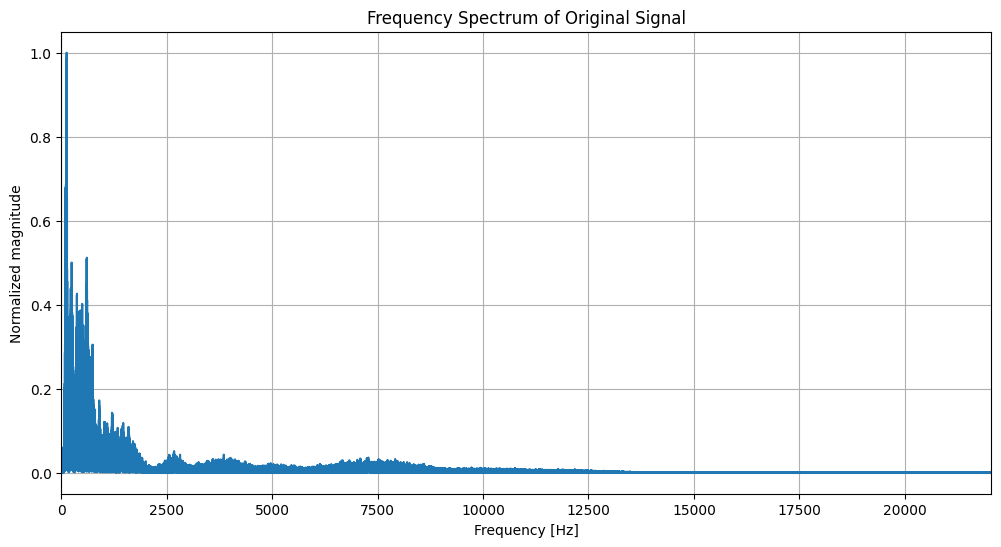

In [88]:
# Plot time-domain waveform (first 0.05 seconds)
plt.figure(figsize=(12,4))
plt.plot(time[:int(0.05*samplerate)], data[:int(0.05*samplerate)])
plt.title("Original Signal Waveform (first 0.05 sec)")
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Plot frequency spectrum
plt.figure(figsize=(12,6))
plt.plot(org_freqs, org_magnitude)
plt.xlim(0, samplerate/2)
plt.title("Frequency Spectrum of Original Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized magnitude")
plt.grid()
plt.show()

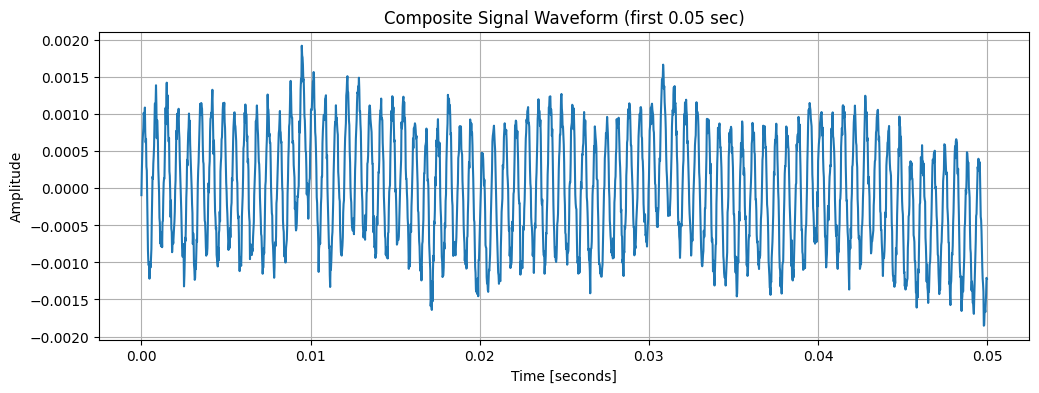

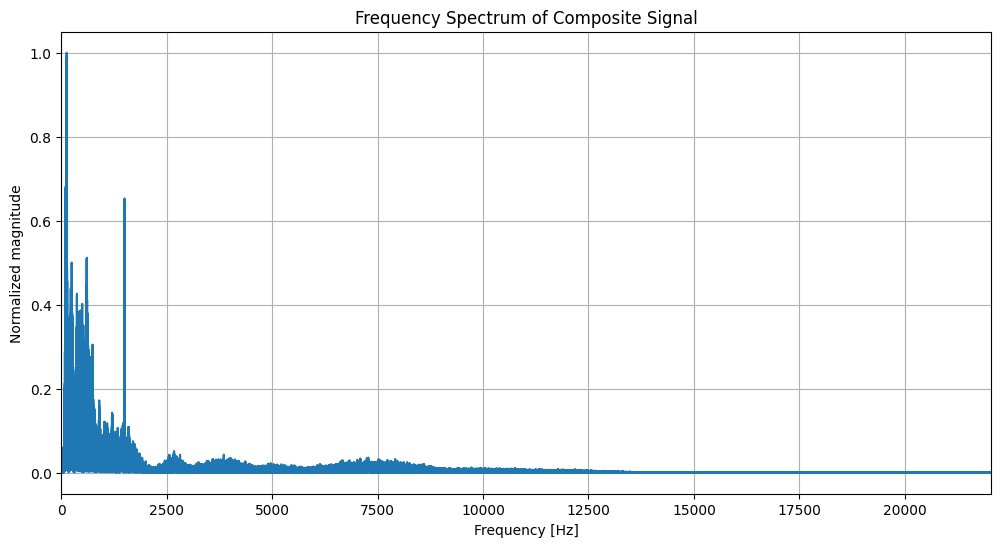

In [77]:
# Plot time-domain waveform (first 0.05 seconds)
plt.figure(figsize=(12,4))
plt.plot(time[:int(0.05*samplerate)], composite[:int(0.05*samplerate)])
plt.title("Composite Signal Waveform (first 0.05 sec)")
plt.xlabel("Time [seconds]")
plt.ylabel("Amplitude")
plt.grid()
plt.show()

# Plot frequency spectrum
plt.figure(figsize=(12,6))
plt.plot(freqs, magnitude)
plt.xlim(0, samplerate/2)
plt.title("Frequency Spectrum of Composite Signal")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Normalized magnitude")
plt.grid()
plt.show()

In [ ]:
# Identify prominent peaks in the spectrum
# Use a simple threshold on magnitude to pick peaks
threshold = 0.65  # peaks above 65% max amplitude
prominent_freqs = freqs[magnitude > threshold]

print("Prominent frequency components in the composite signal (above 90% magnitude):")
for f in prominent_freqs:
    print(f"{f:.1f} Hz")

Prominent frequency components in the composite signal (above 90% magnitude):
100.5 Hz
109.4 Hz
111.1 Hz
113.5 Hz
114.5 Hz
115.2 Hz
115.4 Hz
115.8 Hz
116.4 Hz
116.7 Hz
117.3 Hz
117.5 Hz
117.6 Hz
117.7 Hz
117.9 Hz
118.0 Hz
118.2 Hz
118.9 Hz
119.1 Hz
119.2 Hz
119.7 Hz
119.9 Hz
120.0 Hz
120.3 Hz
121.5 Hz
121.6 Hz
121.8 Hz
121.9 Hz
122.0 Hz
122.1 Hz
122.1 Hz
122.1 Hz
122.2 Hz
122.2 Hz
122.7 Hz
123.1 Hz
123.2 Hz
123.4 Hz
123.7 Hz
123.7 Hz
123.8 Hz
124.3 Hz
125.1 Hz
125.5 Hz
125.9 Hz
126.0 Hz
126.2 Hz
126.2 Hz
126.3 Hz
126.5 Hz
126.5 Hz
126.6 Hz
127.3 Hz
127.5 Hz
127.7 Hz
127.8 Hz
128.6 Hz
129.3 Hz
130.4 Hz
130.7 Hz
130.7 Hz
130.9 Hz
131.5 Hz
131.7 Hz
132.0 Hz
132.1 Hz
132.5 Hz
135.6 Hz
1500.0 Hz


### Explanation:

- The FFT of the **composite signal** reveals peaks corresponding to original audio frequencies plus the added tone frequency.
- We see a clear peak near your tone frequency (1500 Hz in this example), confirming the tone's presence.
- This method can be extended to multiple tones or other signals.

---

Zeroing 280 frequency bins around 1500 Hz
Mean Squared Error between original and recovered (notch filtered): 0.00000041


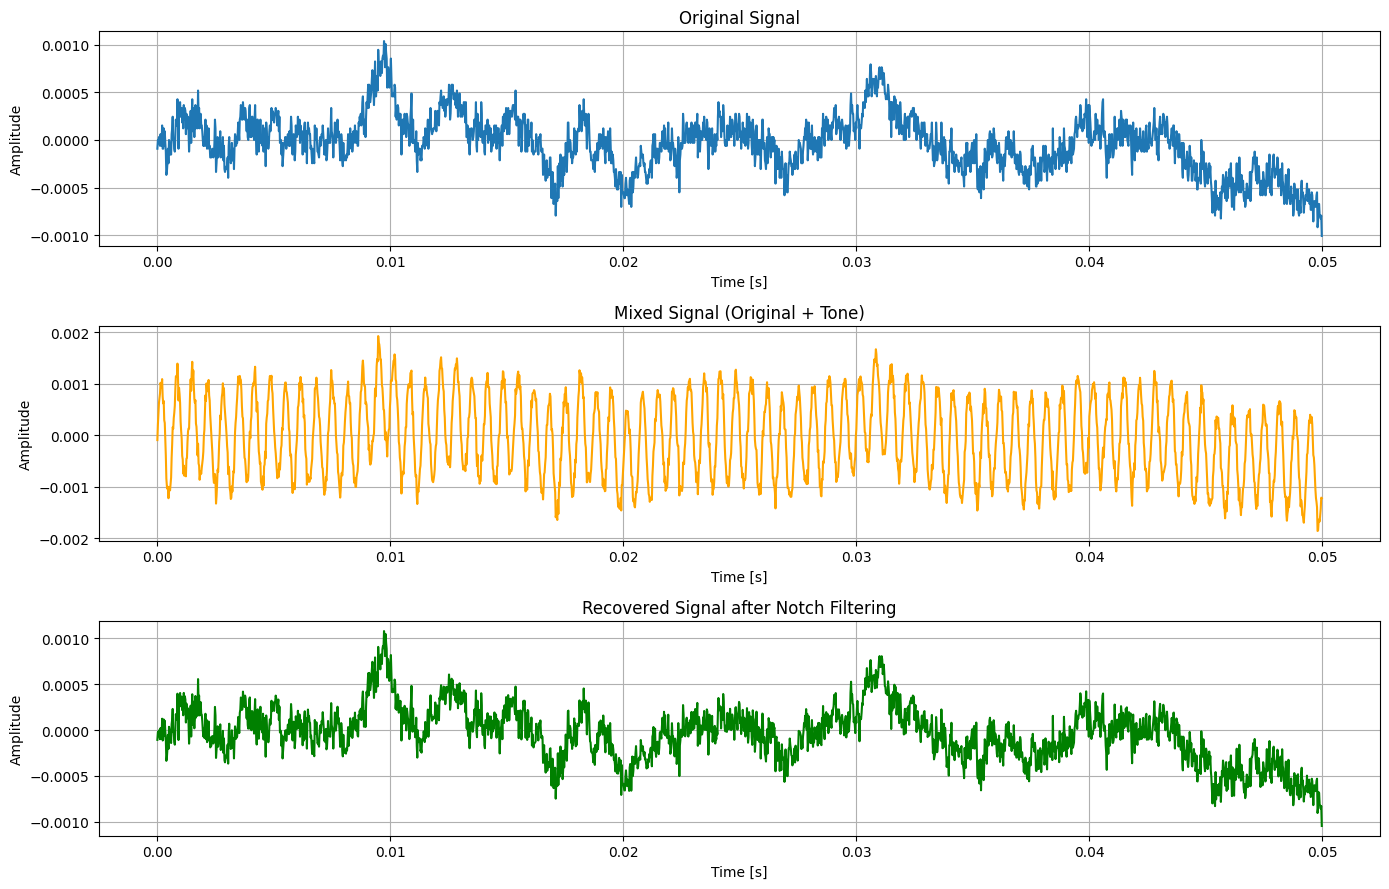

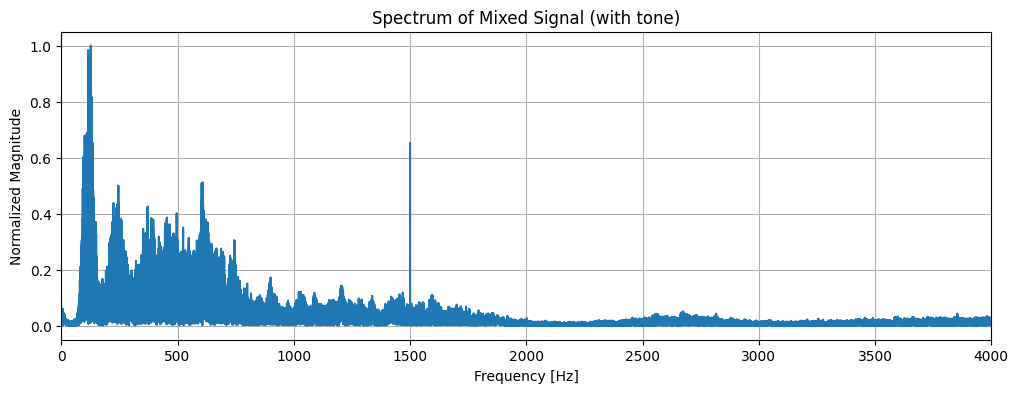

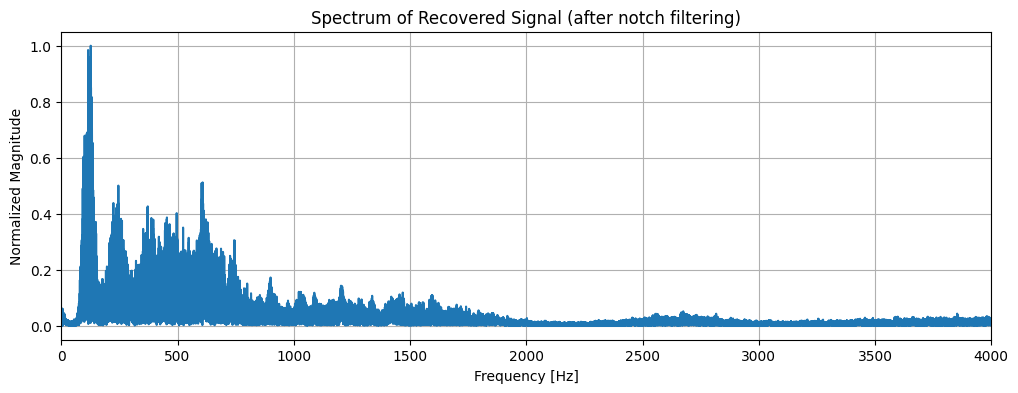

In [ ]:
# Band-stop (notch) filter parameters
notch_width = 5  # Hz, width of frequency band to zero out around tone_freq

# Find indices in FFT freq array around the notch frequency
notch_indices = np.where(np.abs(freqs - tone_freq) <= notch_width)[0]

print(f"Zeroing {len(notch_indices)} frequency bins around {tone_freq} Hz")

# Zero out the notch frequency bins (attenuation to zero)
fft_vals[notch_indices] = 0

# Inverse FFT to get time-domain signal without the tone
recovered_signal = np.fft.irfft(fft_vals, n=N)

# Clip recovered signal if outside [-1,1]
max_val = np.max(np.abs(recovered_signal))
if max_val > 1:
    recovered_signal = recovered_signal / max_val

# Calculate MSE vs original
mse = np.mean((original_data - recovered_signal) ** 2)
print(f"Mean Squared Error between original and recovered (notch filtered): {mse:.8f}")

# Plot waveforms (first 0.05 seconds)
samples_plot = int(0.05 * samplerate)
t_plot = time[:samples_plot]

plt.figure(figsize=(14,9))

plt.subplot(3,1,1)
plt.plot(t_plot, original_data[:samples_plot])
plt.title("Original Signal")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3,1,2)
plt.plot(t_plot, composite[:samples_plot], color='orange')
plt.title("Mixed Signal (Original + Tone)")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

plt.subplot(3,1,3)
plt.plot(t_plot, recovered_signal[:samples_plot], color='green')
plt.title("Recovered Signal after Notch Filtering")
plt.xlabel("Time [s]")
plt.ylabel("Amplitude")
plt.grid()

plt.tight_layout()
plt.show()

# Plot frequency spectra to verify tone removal

def plot_spectrum(signal, fs, title):
    N_fft = len(signal)
    freqs = np.fft.rfftfreq(N_fft, d=1/fs)
    fft_vals = np.abs(np.fft.rfft(signal))
    fft_vals /= np.max(fft_vals)
    plt.figure(figsize=(12,4))
    plt.plot(freqs, fft_vals)
    plt.title(title)
    plt.xlabel("Frequency [Hz]")
    plt.ylabel("Normalized Magnitude")
    plt.xlim(0, 4000)  # limit x-axis for clear view
    plt.grid()
    plt.show()

plot_spectrum(composite, samplerate, "Spectrum of Mixed Signal (with tone)")
plot_spectrum(recovered_signal, samplerate, "Spectrum of Recovered Signal (after notch filtering)")




## Explanation

- We create a **notch filter by zeroing FFT bins** around the tone frequency ± a small bandwidth (`notch_width`).
- Inverse FFT reconstructs the time-domain signal with the tone component removed.
- MSE quantifies the similarity to the original (lower is better).
- Waveform plots show original, mixed, and recovered signals for visual comparison.
- Spectra plots validate the removal of the tone frequency peak.

## How frequency analysis helps isolate audio components for reliable recognition

- **Frequency domain analysis (e.g., FFT)** decomposes audio into constituent sinusoidal frequency components.
- Speech and audio signals have characteristic frequency patterns (formants, harmonics).
- Noise or interfering signals (like our added tone) show up as narrow peaks or distinct patterns.
- By analyzing frequency components, you can:
  - Identify and **filter out noise or interference** (e.g., notch filters target specific tones).
  - Focus on speech formant regions crucial for recognition (~300-3400 Hz for telephony).
  - Extract features like MFCC or spectral envelopes reliably, improving recognition accuracy.
- Thus, frequency analysis provides the **basis for selective filtering and feature extraction**, enabling reliable speech and audio recognition despite background interference.